In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sectoral_tfp_df_file_path = '../raw_data/productivity_data/major-industry-total-factor-productivity-klems.xlsx'
sectoral_tfp_df = pd.read_excel(sectoral_tfp_df_file_path, header=2)

In [4]:
bds_sec_file_path = '../raw_data/dynamism_data/bds2022_sec.csv'
bds_sec = pd.read_csv(bds_sec_file_path)

In [9]:
sectoral_tfp_df['NAICS'] = sectoral_tfp_df['NAICS'].replace({
    'MN': '31-33',  
    'DM': '33',     
    'ND': '31'     
})

Updated NAICS codes:
['11' '111-112' '113-115' '21' '211' '212' '213' '22' '23' '31-33' '33'
 '31' '321' '327' '331' '332' '333' '334' '335' '3361-3363' '3364-3369'
 '337' '339' '311-312' '313-314' '315-316' '322' '323' '324' '325' '326'
 '42,44-45' '42' '44,45' '48-49' '481' '482' '483' '484' '485' '486'
 '487,488,492' '493' '51' '511' '512' '515,517' '518-519' '52-53' '52'
 '521-522' '523' '524' '525' '53' '531' '532-533' '54-81' '54-56' '54'
 '5411' '5415' '5412-5414,5416-5419' '55' '56' '561' '562' '61-62' '61'
 '62' '621' '622-623' '624' '71-72' '71' '711-712' '713' '72' '721' '722'
 '81']


In [10]:
two_digit_sectoral_df = sectoral_tfp_df[sectoral_tfp_df['NAICS'].str.len() == 2].copy()

print("Two-digit NAICS codes in the new DataFrame:")
print(sorted(two_digit_sectoral_df['NAICS'].unique()))

Two-digit NAICS codes in the new DataFrame:
['11', '21', '22', '23', '31', '33', '42', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81']

Original DataFrame shape: (7290, 42)
Two-digit NAICS DataFrame shape: (1620, 42)

First few rows of two_digit_naics_df:
  NAICS                                     Industry        Basis  \
0    11  Agriculture, forestry, fishing, and hunting  All workers   
1    11  Agriculture, forestry, fishing, and hunting  All workers   
2    11  Agriculture, forestry, fishing, and hunting  All workers   
3    11  Agriculture, forestry, fishing, and hunting  All workers   
4    11  Agriculture, forestry, fishing, and hunting  All workers   

                     Measure             Units     1987     1988     1989  \
0  Total factor productivity  Index (2017=100)   68.776   63.369   66.843   
1       Real sectoral output  Index (2017=100)    72.72   69.774   73.276   
2            Combined inputs  Index (2017=100)  105.735  110.107  109.624   
3  

In [12]:
long_df = sectoral_tfp_df.melt(
    id_vars=['NAICS', 'Industry', 'Basis', 'Measure', 'Units'], 
    var_name='year', 
    value_name='value'  
)

In [15]:
tfp_long = long_df[long_df['Measure'] == 'Total factor productivity'].copy()
output_long = long_df[long_df['Measure'] == 'Sectoral output'].copy()

In [17]:
output_pivot = output_long.pivot_table(
    values='value', 
    index='year', 
    columns='NAICS', 
    aggfunc='sum',
    fill_value=0
)

weights = (
    output_pivot.apply(lambda row: row / (row.sum() + 1e-10), axis=1)
    .stack()
    .reset_index()
    .rename(columns={0: 'weight'})
)

tfp_with_weights = tfp_long.merge(
    weights,
    on=['year', 'NAICS'],
    how='left'
).fillna({'weight': 0})

C:\Users\Lamb\AppData\Local\Temp\ipykernel_1164\817515597.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  output_pivot = output_long.pivot_table(


In [131]:
tfp_with_weights['Measure'].unique()

array(['Total factor productivity'], dtype=object)

In [ ]:
tfp_units = tfp_with_weights['Units'].value_counts()
print("Units used for Total factor productivity:\n", tfp_units)

tfp_pivoted = tfp_with_weights.pivot(
    index=['NAICS', 'Industry', 'Basis', 'year', 'weight'],
    columns='Units',
    values='value'
).reset_index()

tfp_pivoted.columns.name = None

tfp_pivoted = tfp_pivoted.rename(columns={
    'Index (2017=100)': 'tfp_index_2017',
    '% Change from previous year': 'tfp_pct_change'
})

Units used for Total factor productivity:
 Units
Index (2017=100)               2997
% Change from previous year    2997
Name: count, dtype: int64

First few rows of pivoted TFP data:


NAICS                                     Industry        Basis  year  \
0    11  Agriculture, forestry, fishing, and hunting  All workers  1987   
1    11  Agriculture, forestry, fishing, and hunting  All workers  1988   
2    11  Agriculture, forestry, fishing, and hunting  All workers  1989   
3    11  Agriculture, forestry, fishing, and hunting  All workers  1990   
4    11  Agriculture, forestry, fishing, and hunting  All workers  1991   

     weight tfp_pct_change tfp_index_2017  
0  0.009333           N.A.         68.776  
1  0.008802           -7.9         63.369  
2  0.008845            5.5         66.843  
3  0.008622            5.5         70.492  
4  0.008256            0.8         71.025

In [160]:
tfp_pivoted.isna().sum()

NAICS             0
Industry          0
Basis             0
year              0
weight            0
tfp_pct_change    0
tfp_index_2017    0
dtype: int64

In [ ]:
bds_sec['year'] = bds_sec['year'].astype(int)
bds_87_on = bds_sec[bds_sec['year'] >= 1987]

In [ ]:
tfp_pivoted['year'] = tfp_pivoted['year'].astype(int)

merged = pd.merge(
    bds_87_on,
    tfp_pivoted, 
    on=['NAICS','year'],  
    how='left'
)

In [167]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

year          firms        estabs           emp         denom  \
count   684.000000     684.000000  6.840000e+02  6.840000e+02  6.840000e+02   
mean   2004.500000  263569.961988  3.386948e+05  5.866836e+06  5.832662e+06   
std      10.395897  225128.317520  2.872606e+05  4.874292e+06  4.853131e+06   
min    1987.000000    5354.000000  1.239300e+04  1.493700e+05  1.495870e+05   
25%    1995.750000   59835.250000  7.459775e+04  2.128340e+06  2.103328e+06   
50%    2004.500000  220516.000000  3.074020e+05  4.759006e+06  4.728988e+06   
75%    2013.250000  474775.250000  5.534522e+05  8.210303e+06  8.055515e+06   
max    2022.000000  737428.000000  1.094884e+06  2.120506e+07  2.102796e+07   

        estabs_entry  estabs_entry_rate    estabs_exit  estabs_exit_rate  \
count     684.000000         684.000000     684.000000        684.000000   
mean    37379.024854          11.437156   34075.116959         10.369716   
std     30643.440893           2.975385   28519.644899          2.516603   
min       654.000000           4.005000     575.000000          3.912000   
25%      9412.000000           9.175500    7580.500000          8.525000   
50%     33547.000000          11.494500   30249.000000         10.357500   
75%     61274.000000          13.473500   53555.000000         12.081000   
max    136344.000000          20.840000  128328.000000         21.278000   

       job_creation  job_creation_births  job_creation_rate_births  \
count  6.840000e+02         6.840000e+02                684.000000   
mean   8.654562e+05         2.977018e+05                  5.417298   
std    6.580186e+05         2.525200e+05                  2.220676   
min    1.996600e+04         6.406000e+03                  1.566000   
25%    3.155608e+05         1.019872e+05                  3.934500   
50%    7.358895e+05         2.260015e+05                  5.214500   
75%    1.353749e+06         4.353390e+05                  6.609750   
max    3.082015e+06         1.058285e+06                 13.855000   

       job_creation_rate  job_destruction  job_destruction_deaths  \
count         684.000000     6.840000e+02              684.000000   
mean           15.741762     7.972603e+05           266562.792398   
std             4.819031     6.177803e+05           208825.159798   
min             5.251000     2.070300e+04             6028.000000   
25%            12.273500     2.688122e+05            83841.000000   
50%            15.641000     6.653465e+05           223934.500000   
75%            18.683250     1.236114e+06           418103.750000   
max            37.724000     3.760734e+06           878078.000000   

       job_destruction_continuers  job_destruction_rate_deaths  \
count                6.840000e+02                   684.000000   
mean                 5.306975e+05                     4.903659   
std                  4.181386e+05                     1.922407   
min                  1.317000e+04                     0.824000   
25%                  1.803600e+05                     3.584000   
50%                  4.375140e+05                     4.803000   
75%                  8.233258e+05                     6.204250   
max                  2.901096e+06                    11.992000   

       job_destruction_rate  net_job_creation  net_job_creation_rate  \
count            684.000000      6.840000e+02             684.000000   
mean              14.632178      6.819591e+04               1.109554   
std                4.745962      2.421962e+05               3.957971   
min                5.264000     -2.232807e+06             -29.845000   
25%               11.486000     -5.001250e+03              -0.389500   
50%               14.285500      5.525200e+04               1.611000   
75%               17.314750      1.644072e+05               2.956250   
max               39.072000      1.593988e+06              26.221000   

       reallocation_rate  firmdeath_firms  firmdeath_estabs  firmdeath_emp  \
count         684.000000       684.000000 

In [168]:
merged.columns

Index(['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry',
       'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers',
       'job_creation_rate_births', 'job_creation_rate', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'job_destruction_rate_deaths', 'job_destruction_rate',
       'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp', 'Industry',
       'Basis', 'weight', 'tfp_pct_change', 'tfp_index_2017'],
      dtype='object')

In [174]:
output_path = '../processed_data/two_digit_NAICS_bds_tfp.csv'
merged.to_csv(output_path, index=False)
print(f"Data saved to {output_path}")

Data saved to /Users/danielseymour/Developer/EC334-Summative/processed_data/two_digit_NAICS_bds_tfp.csv


In [173]:
merged['firms_percent_destroyed'] = (merged['firmdeath_firms'] / merged['firms']) * 100

Available NAICS codes in your dataset:
['11' '21' '22' '23' '31-33' '42' '44-45' '48-49' '51' '52' '53' '54' '55'
 '56' '61' '62' '71' '72' '81']

To create plots, use:
1. plot_industry_time_series(merged, naics_code='21')  # for specific NAICS
2. plot_multiple_industries_comparison(merged, naics_codes=['21', '22', '23'])
3. plot_productivity_distributions(merged)
4. summary_stats = create_summary_stats(merged)


KeyError: 'Index (2017=100)'

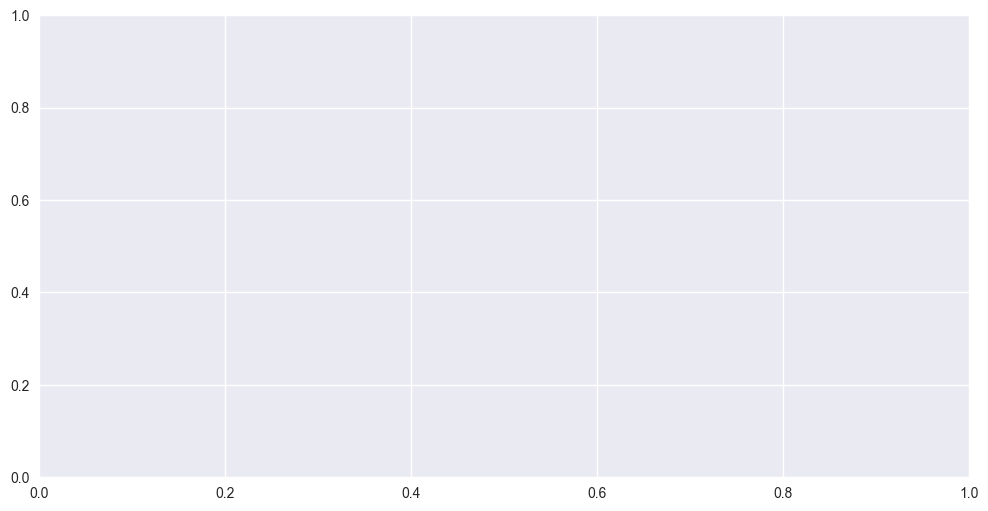

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_industry_time_series(df, naics_code=None, industry_name=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if naics_code:
        industry_data = df[df['NAICS'] == naics_code].copy()
        title_suffix = f"NAICS {naics_code}"
    elif industry_name:
        industry_data = df[df['Industry'].str.contains(industry_name, case=False, na=False)].copy()
        title_suffix = industry_name
    else:

        naics_code = df['NAICS'].iloc[0]
        industry_data = df[df['NAICS'] == naics_code].copy()
        title_suffix = f"NAICS {naics_code}"
    
    if not industry_data.empty:
        industry_data = industry_data.sort_values('year')
        
        ax.plot(industry_data['year'], industry_data['Index (2017=100)'], 
                marker='o', linewidth=2.5, markersize=6)
        
        ax.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='2017 Baseline')
        
        ax.set_title(f'Productivity Index Time Series - {title_suffix}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Index (2017=100)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        for i, row in industry_data.iterrows():
            if row['year'] % 3 == 0: 
                ax.annotate(f"{row['Index (2017=100)']:.1f}", 
                           (row['year'], row['Index (2017=100)']),
                           textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    return fig

def plot_multiple_industries_comparison(df, naics_codes=None, max_industries=5):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    if naics_codes is None:
        # Select top industries by data availability
        naics_codes = df['NAICS'].value_counts().head(max_industries).index.tolist()
    
    for naics in naics_codes:
        industry_data = df[df['NAICS'] == naics].copy().sort_values('year')
        if not industry_data.empty:
            industry_name = industry_data['Industry'].iloc[0] if 'Industry' in industry_data.columns else f"NAICS {naics}"
            ax.plot(industry_data['year'], industry_data['Index (2017=100)'], 
                   marker='o', linewidth=2, label=f"{naics}: {industry_name[:30]}...")
    
    ax.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='2017 Baseline')
    ax.set_title('Productivity Index Comparison Across Industries', fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Index (2017=100)', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_productivity_distributions(df):
    """
    Create distribution plots for key metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0,0].hist(df['Index (2017=100)'].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[0,0].axvline(100, color='red', linestyle='--', label='2017 Baseline')
    axes[0,0].set_title('Distribution of Productivity Index')
    axes[0,0].set_xlabel('Index (2017=100)')
    axes[0,0].legend()
    
    axes[0,1].hist(df['% Change from previous year'].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(0, color='red', linestyle='--', label='No Change')
    axes[0,1].set_title('Distribution of Year-over-Year % Change')
    axes[0,1].set_xlabel('% Change from previous year')
    axes[0,1].legend()
    
    if 'emp' in df.columns:
        scatter_data = df.dropna(subset=['emp', 'Index (2017=100)'])
        axes[1,0].scatter(scatter_data['emp'], scatter_data['Index (2017=100)'], alpha=0.6)
        axes[1,0].set_title('Employment vs Productivity Index')
        axes[1,0].set_xlabel('Employment')
        axes[1,0].set_ylabel('Index (2017=100)')
        axes[1,0].set_xscale('log')
    
    if 'firms' in df.columns:
        scatter_data = df.dropna(subset=['firms', 'Index (2017=100)'])
        axes[1,1].scatter(scatter_data['firms'], scatter_data['Index (2017=100)'], alpha=0.6)
        axes[1,1].set_title('Number of Firms vs Productivity Index')
        axes[1,1].set_xlabel('Number of Firms')
        axes[1,1].set_ylabel('Index (2017=100)')
        axes[1,1].set_xscale('log')
    
    plt.tight_layout()
    return fig

def create_summary_stats(df):
    key_vars = ['Index (2017=100)', '% Change from previous year', 'emp', 'firms', 'estabs']
    available_vars = [var for var in key_vars if var in df.columns]
    
    summary = df[available_vars].describe()
    return summary


if not merged.empty:
    first_naics = merged['NAICS'].iloc[0]
    fig1 = plot_industry_time_series(merged, naics_code=first_naics)
    plt.show()
    
    print("\nSummary Statistics:")
    print(create_summary_stats(merged))

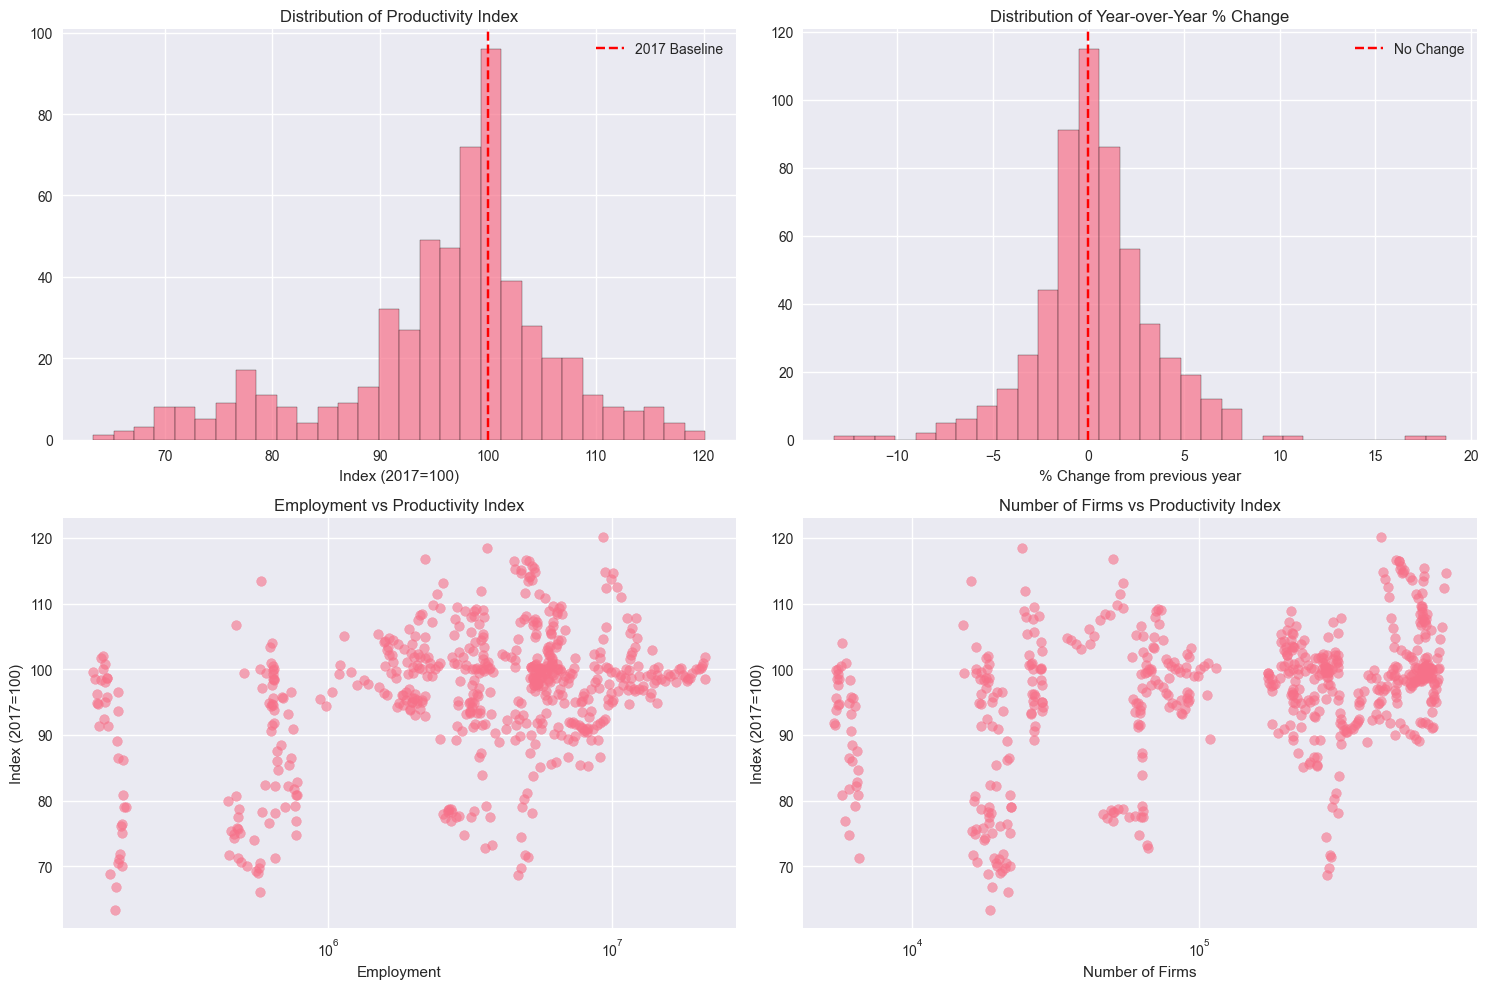

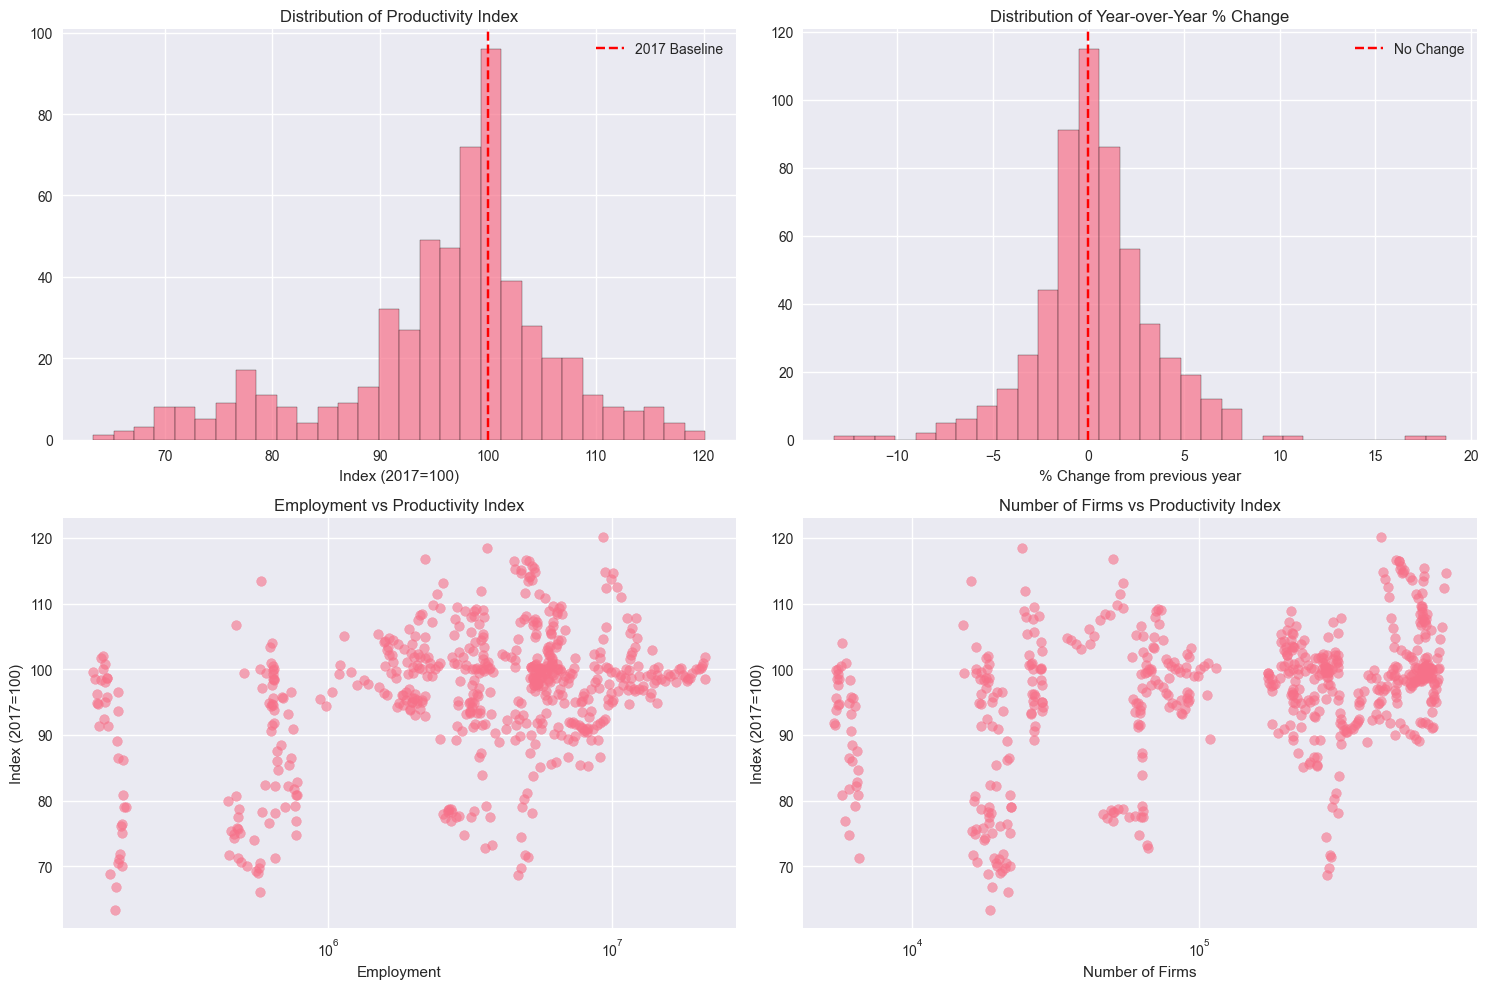

In [79]:
plot_productivity_distributions(merged)


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def create_moving_averages(df, window=3):
    """
    Create 3-year moving averages for job dynamics variables
    """
    # Job dynamics variables to smooth
    job_vars = [
        'job_creation', 'job_creation_rate', 'job_creation_births', 'job_creation_continuers',
        'job_destruction', 'job_destruction_rate', 'job_destruction_deaths', 'job_destruction_continuers',
        'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
        'estabs_entry', 'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate',
        '% Change from previous year', 'Index (2017=100)'
    ]
    
    # Only include variables that exist in the dataframe
    available_vars = [var for var in job_vars if var in df.columns]
    
    # Create moving averages by NAICS code
    df_ma = df.copy()
    
    for naics in df['NAICS'].unique():
        mask = df['NAICS'] == naics
        naics_data = df[mask].sort_values('year')
        
        for var in available_vars:
            if var in naics_data.columns:
                # Calculate 3-year moving average
                ma_values = naics_data[var].rolling(window=window, center=True, min_periods=1).mean()
                df_ma.loc[mask, f'{var}_MA3'] = ma_values.values
    
    return df_ma

def run_productivity_job_regressions(df_ma):
    """
    Run various regressions relating job dynamics to productivity
    """
    results = {}
    
    # Define regression specifications
    regressions = {
        'Net Job Creation Impact': {
            'y': 'Index (2017=100)_MA3',
            'x': ['net_job_creation_rate_MA3', 'reallocation_rate_MA3']
        },
        'Job Creation vs Destruction': {
            'y': '% Change from previous year_MA3',
            'x': ['job_creation_rate_MA3', 'job_destruction_rate_MA3']
        },
        'Entry vs Exit Effects': {
            'y': 'Index (2017=100)_MA3',
            'x': ['estabs_entry_rate_MA3', 'estabs_exit_rate_MA3', 'net_job_creation_rate_MA3']
        },
        'Birth vs Continuing Establishments': {
            'y': '% Change from previous year_MA3',
            'x': ['job_creation_rate_births_MA3', 'job_creation_continuers_MA3', 'job_destruction_rate_MA3']
        }
    }
    
    for reg_name, spec in regressions.items():
        print(f"\n{'='*60}")
        print(f"REGRESSION: {reg_name}")
        print(f"{'='*60}")
        
        # Check if all variables exist
        all_vars = [spec['y']] + spec['x']
        available_vars = [var for var in all_vars if var in df_ma.columns]
        
        if len(available_vars) == len(all_vars):
            # Create regression dataset
            reg_data = df_ma[available_vars + ['NAICS', 'year']].dropna()
            
            if len(reg_data) > 10:  # Ensure sufficient observations
                y = reg_data[spec['y']]
                X = reg_data[spec['x']]
                
                # Add constant for intercept
                X_with_const = sm.add_constant(X)
                
                # Run regression
                model = sm.OLS(y, X_with_const).fit()
                results[reg_name] = {
                    'model': model,
                    'data': reg_data,
                    'r_squared': model.rsquared,
                    'adj_r_squared': model.rsquared_adj,
                    'n_obs': len(reg_data)
                }
                
                # Print results
                print(f"Observations: {len(reg_data)}")
                print(f"R-squared: {model.rsquared:.4f}")
                print(f"Adj. R-squared: {model.rsquared_adj:.4f}")
                print(f"F-statistic p-value: {model.f_pvalue:.4f}")
                print("\nCoefficients:")
                print(model.summary().tables[1])
                
            else:
                print(f"Insufficient data ({len(reg_data)} observations)")
        else:
            missing_vars = [var for var in all_vars if var not in df_ma.columns]
            print(f"Missing variables: {missing_vars}")
    
    return results

def plot_regression_diagnostics(results):
    """
    Create diagnostic plots for regression results
    """
    n_regressions = len(results)
    if n_regressions == 0:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (reg_name, result) in enumerate(results.items()):
        if i >= 4:  # Only plot first 4 regressions
            break
            
        model = result['model']
        reg_data = result['data']
        
        # Residuals vs Fitted
        fitted_values = model.fittedvalues
        residuals = model.resid
        
        axes[i].scatter(fitted_values, residuals, alpha=0.6)
        axes[i].axhline(y=0, color='red', linestyle='--')
        axes[i].set_xlabel('Fitted Values')
        axes[i].set_ylabel('Residuals')
        axes[i].set_title(f'{reg_name}\nResiduals vs Fitted (R² = {result["r_squared"]:.3f})')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def industry_specific_analysis(df_ma, naics_codes=None):
    """
    Run regressions for specific industries
    """
    if naics_codes is None:
        # Use top 5 industries by data availability
        naics_codes = df_ma['NAICS'].value_counts().head(5).index.tolist()
    
    industry_results = {}
    
    for naics in naics_codes:
        print(f"\n{'='*50}")
        print(f"INDUSTRY ANALYSIS: NAICS {naics}")
        print(f"{'='*50}")
        
        industry_data = df_ma[df_ma['NAICS'] == naics].copy()
        
        if len(industry_data) >= 5:  # Need minimum observations
            # Simple regression: Net job creation rate vs productivity change
            if all(col in industry_data.columns for col in ['% Change from previous year_MA3', 'net_job_creation_rate_MA3']):
                y = industry_data['% Change from previous year_MA3'].dropna()
                x = industry_data['net_job_creation_rate_MA3'].dropna()
                
                # Align the data
                common_index = y.index.intersection(x.index)
                if len(common_index) >= 3:
                    y_aligned = y.loc[common_index]
                    x_aligned = x.loc[common_index]
                    
                    # Run regression
                    X_with_const = sm.add_constant(x_aligned)
                    model = sm.OLS(y_aligned, X_with_const).fit()
                    
                    industry_results[naics] = {
                        'model': model,
                        'r_squared': model.rsquared,
                        'coefficient': model.params.iloc[-1],
                        'p_value': model.pvalues.iloc[-1]
                    }
                    
                    print(f"Net Job Creation Rate → Productivity Change")
                    print(f"Coefficient: {model.params.iloc[-1]:.4f}")
                    print(f"P-value: {model.pvalues.iloc[-1]:.4f}")
                    print(f"R-squared: {model.rsquared:.4f}")
                else:
                    print("Insufficient aligned data")
            else:
                print("Required variables not available")
        else:
            print(f"Insufficient data ({len(industry_data)} observations)")
    
    return industry_results

def plot_job_dynamics_trends(df_ma, naics_codes=None):
    """
    Plot job creation/destruction trends with moving averages
    """
    if naics_codes is None:
        naics_codes = df_ma['NAICS'].value_counts().head(4).index.tolist()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, naics in enumerate(naics_codes):
        if i >= 4:
            break
            
        industry_data = df_ma[df_ma['NAICS'] == naics].sort_values('year')
        
        if not industry_data.empty and 'job_creation_rate_MA3' in df_ma.columns:
            # Plot job creation and destruction rates
            axes[i].plot(industry_data['year'], industry_data['job_creation_rate_MA3'], 
                        label='Job Creation Rate (3Y MA)', marker='o', linewidth=2)
            
            if 'job_destruction_rate_MA3' in df_ma.columns:
                axes[i].plot(industry_data['year'], industry_data['job_destruction_rate_MA3'], 
                            label='Job Destruction Rate (3Y MA)', marker='s', linewidth=2)
            
            if 'net_job_creation_rate_MA3' in df_ma.columns:
                axes[i].plot(industry_data['year'], industry_data['net_job_creation_rate_MA3'], 
                            label='Net Job Creation Rate (3Y MA)', marker='^', linewidth=2)
            
            axes[i].set_title(f'NAICS {naics}: Job Dynamics (3-Year MA)')
            axes[i].set_xlabel('Year')
            axes[i].set_ylabel('Rate')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# MAIN EXECUTION
def run_complete_analysis(df):
    """
    Run the complete job dynamics regression analysis
    """
    print("Creating 3-year moving averages...")
    df_ma = create_moving_averages(df)
    
    print(f"Created moving averages for {len([col for col in df_ma.columns if '_MA3' in col])} variables")
    
    # Run pooled regressions
    print("\n" + "="*80)
    print("POOLED REGRESSION ANALYSIS")
    print("="*80)
    regression_results = run_productivity_job_regressions(df_ma)
    
    # Industry-specific analysis
    print("\n" + "="*80)
    print("INDUSTRY-SPECIFIC ANALYSIS")
    print("="*80)
    industry_results = industry_specific_analysis(df_ma)
    
    # Create plots
    if regression_results:
        fig1 = plot_regression_diagnostics(regression_results)
        plt.show()
    
    fig2 = plot_job_dynamics_trends(df_ma)
    plt.show()
    
    return df_ma, regression_results, industry_results

# Usage
print("Starting job dynamics regression analysis...")
print("Call: df_ma, reg_results, ind_results = run_complete_analysis(merged)")

Starting job dynamics regression analysis...
Call: df_ma, reg_results, ind_results = run_complete_analysis(merged)


Creating 3-year moving averages...
Created moving averages for 17 variables

POOLED REGRESSION ANALYSIS

REGRESSION: Net Job Creation Impact
Observations: 576
R-squared: 0.0626
Adj. R-squared: 0.0594
F-statistic p-value: 0.0000

Coefficients:
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       103.9874      1.456     71.403      0.000     101.127     106.848
net_job_creation_rate_MA3     0.3468      0.147      2.354      0.019       0.057       0.636
reallocation_rate_MA3        -0.2902      0.049     -5.876      0.000      -0.387      -0.193

REGRESSION: Job Creation vs Destruction
Observations: 576
R-squared: 0.0274
Adj. R-squared: 0.0240
F-statistic p-value: 0.0004

Coefficients:
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

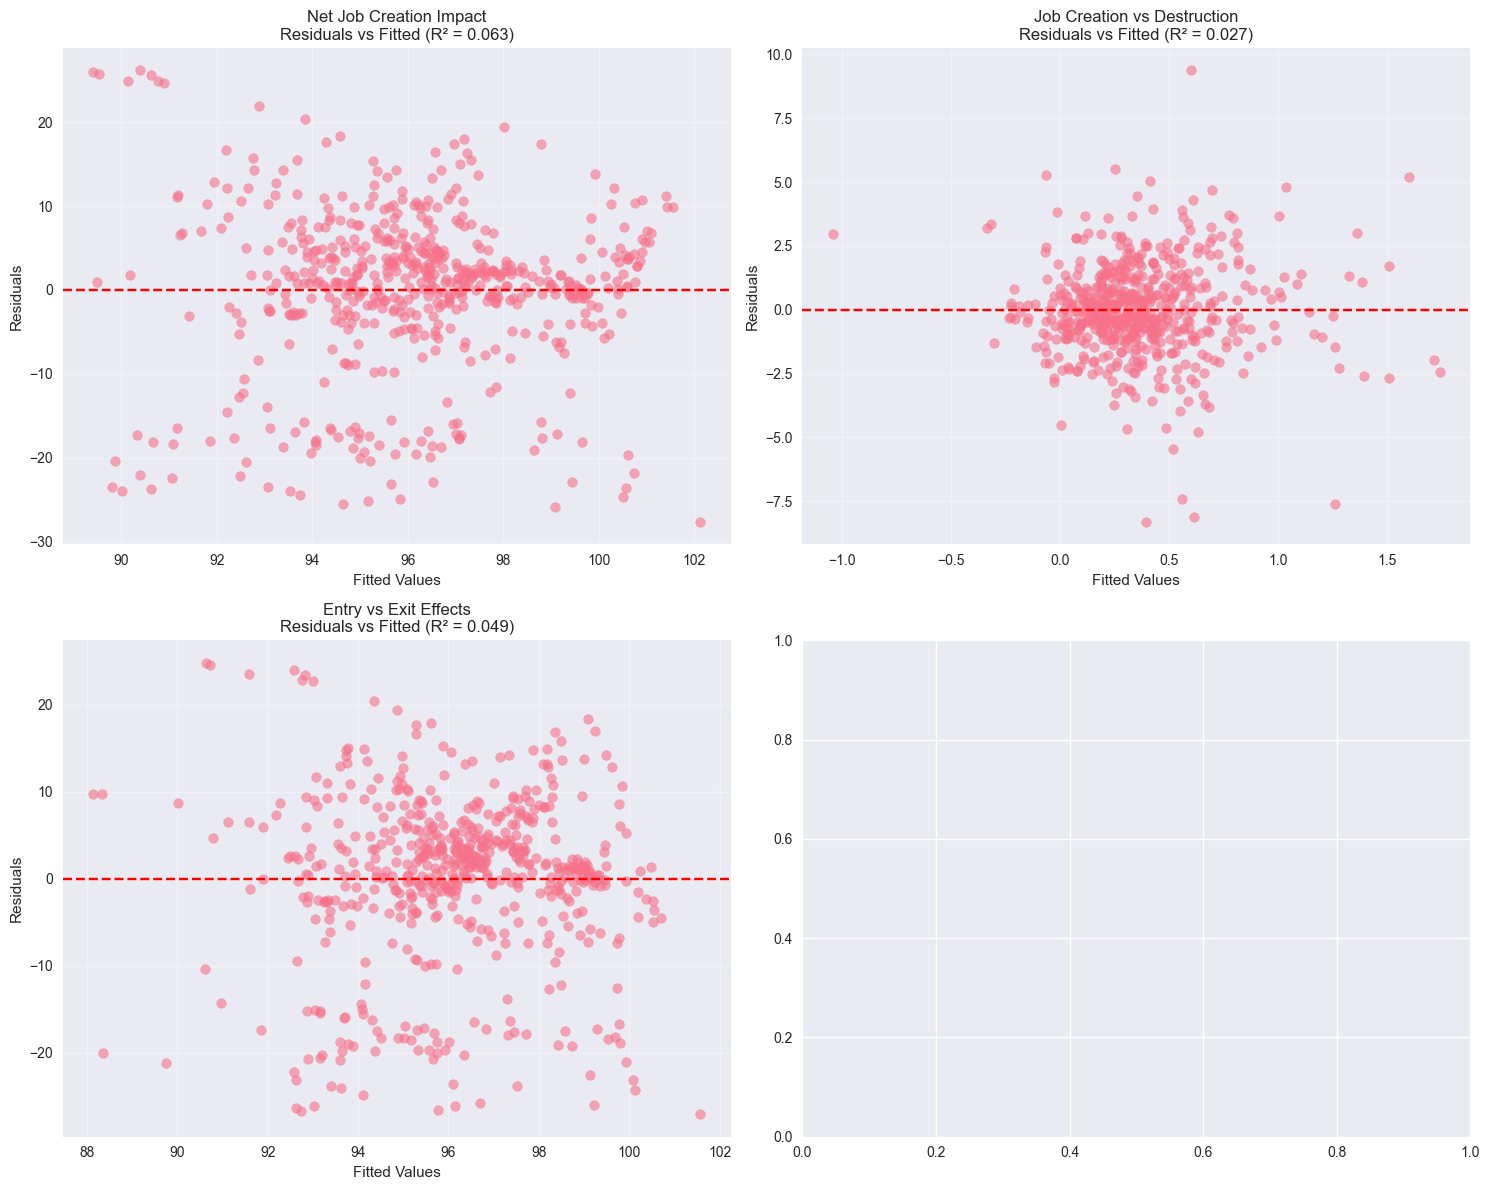

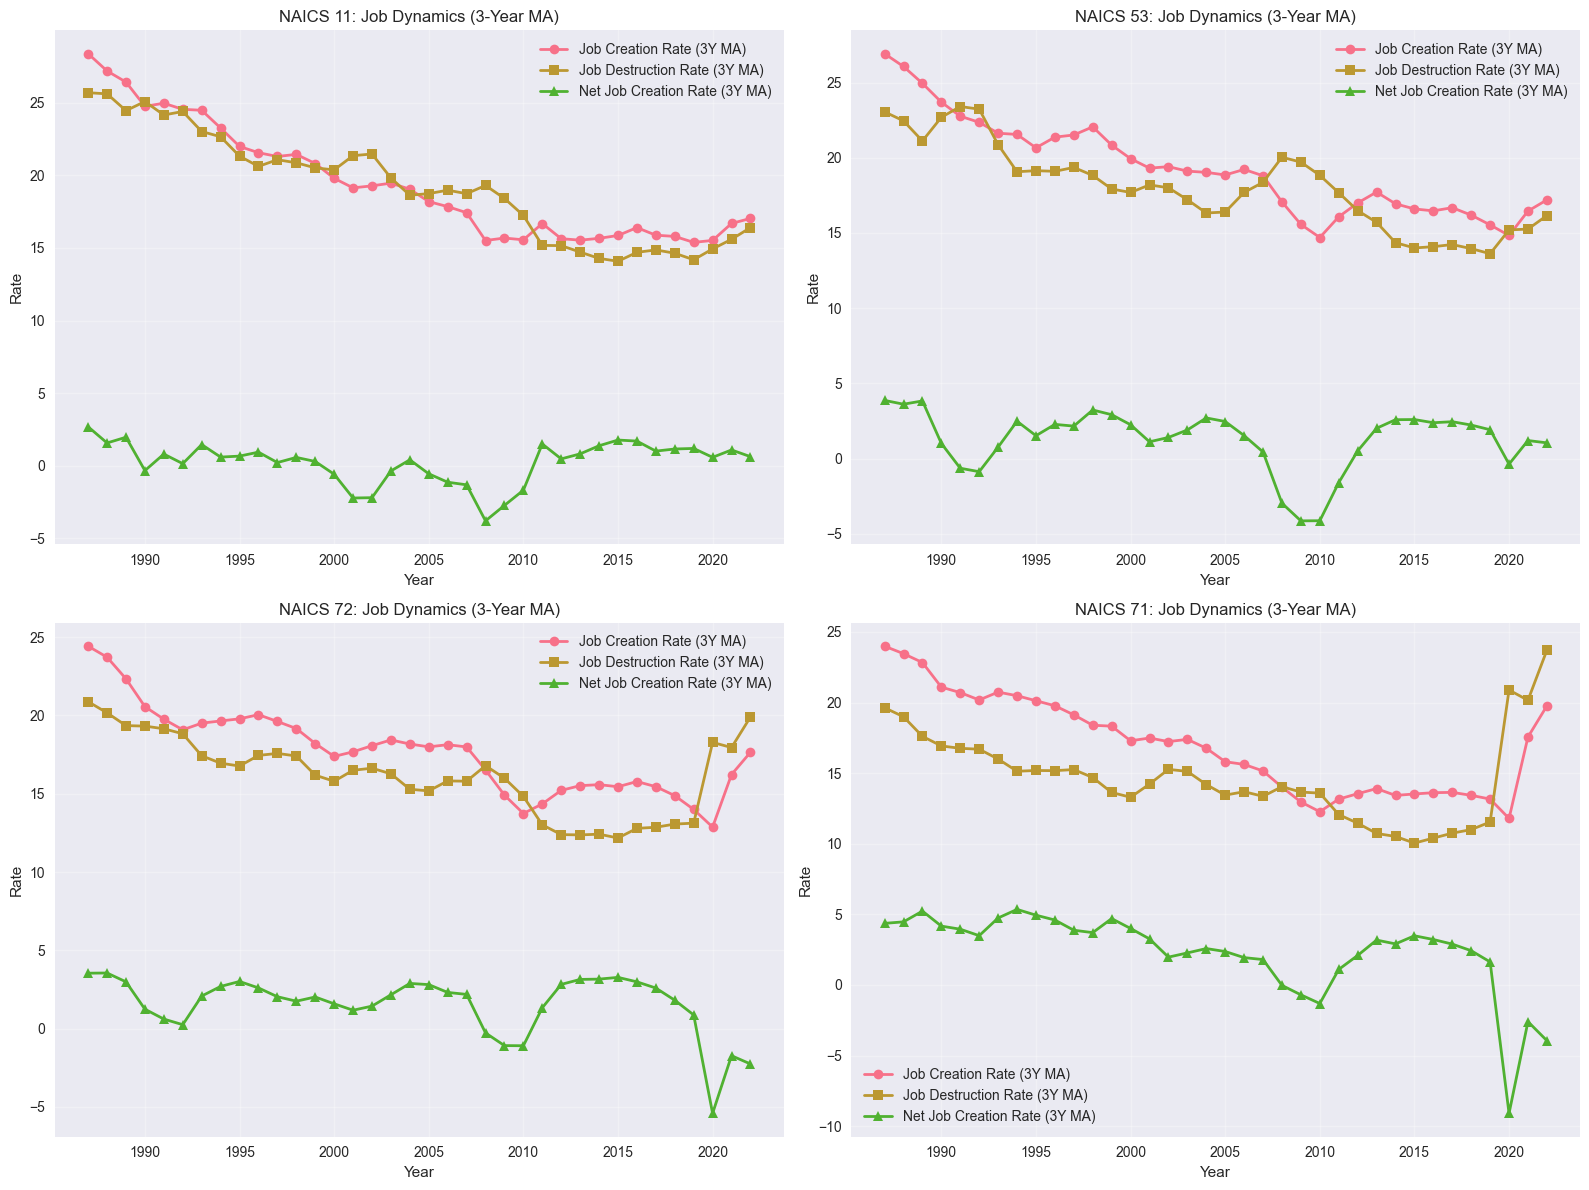

In [82]:
df_ma, regression_results, industry_results = run_complete_analysis(merged)


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def create_simple_moving_averages(df, variables, window=3):
    """
    Create 3-year moving averages for specified variables
    """
    df_ma = df.copy()
    
    # Sort by NAICS and year for proper time series
    df_ma = df_ma.sort_values(['NAICS', 'year'])
    
    for naics in df['NAICS'].unique():
        mask = df_ma['NAICS'] == naics
        
        for var in variables:
            if var in df_ma.columns:
                # Calculate 3-year moving average for this industry
                ma_values = df_ma.loc[mask, var].rolling(window=window, center=True, min_periods=1).mean()
                df_ma.loc[mask, f'{var}_MA3'] = ma_values
    
    return df_ma

def plot_job_creation_ma(df_ma, naics_codes=None, max_industries=6):
    """
    Plot job creation with 3-year moving average
    """
    if naics_codes is None:
        # Get top industries by data availability
        naics_codes = df_ma['NAICS'].value_counts().head(max_industries).index.tolist()
    
    n_industries = len(naics_codes)
    n_cols = 3
    n_rows = (n_industries + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = [axes] if n_industries == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, naics in enumerate(naics_codes):
        industry_data = df_ma[df_ma['NAICS'] == naics].sort_values('year')
        
        if not industry_data.empty and 'job_creation' in industry_data.columns:
            ax = axes[i] if n_industries > 1 else axes
            
            # Plot original data
            ax.plot(industry_data['year'], industry_data['job_creation'], 
                   alpha=0.3, color='lightblue', linewidth=1, label='Original')
            
            # Plot moving average
            if 'job_creation_MA3' in industry_data.columns:
                ax.plot(industry_data['year'], industry_data['job_creation_MA3'], 
                       color='darkblue', linewidth=3, marker='o', markersize=4, 
                       label='3-Year Moving Average')
            
            # Get industry name if available
            industry_name = industry_data['Industry'].iloc[0] if 'Industry' in industry_data.columns else f"NAICS {naics}"
            ax.set_title(f'{naics}: {industry_name[:40]}', fontsize=12, fontweight='bold')
            ax.set_xlabel('Year')
            ax.set_ylabel('Job Creation')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    if n_industries < len(axes):
        for i in range(n_industries, len(axes)):
            axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Job Creation: Original vs 3-Year Moving Average', fontsize=16, y=1.02)
    return fig

def plot_single_variable_comparison(df_ma, variable, naics_codes=None, max_industries=6):
    """
    Plot any variable with its moving average for comparison
    """
    if naics_codes is None:
        naics_codes = df_ma['NAICS'].value_counts().head(max_industries).index.tolist()
    
    n_industries = len(naics_codes)
    n_cols = 2
    n_rows = (n_industries + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_industries == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, naics in enumerate(naics_codes):
        industry_data = df_ma[df_ma['NAICS'] == naics].sort_values('year')
        
        if not industry_data.empty and variable in industry_data.columns:
            ax = axes[i] if n_industries > 1 else axes
            
            # Plot original data
            ax.plot(industry_data['year'], industry_data[variable], 
                   alpha=0.4, color='gray', linewidth=1, label='Original', marker='.')
            
            # Plot moving average
            ma_var = f'{variable}_MA3'
            if ma_var in industry_data.columns:
                ax.plot(industry_data['year'], industry_data[ma_var], 
                       color='red', linewidth=3, marker='o', markersize=5, 
                       label='3-Year Moving Average')
            
            # Get industry name
            industry_name = industry_data['Industry'].iloc[0] if 'Industry' in industry_data.columns else f"NAICS {naics}"
            ax.set_title(f'{naics}: {industry_name[:30]}', fontsize=11, fontweight='bold')
            ax.set_xlabel('Year')
            ax.set_ylabel(variable.replace('_', ' ').title())
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    if n_industries < len(axes):
        for i in range(n_industries, len(axes)):
            axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'{variable.replace("_", " ").title()}: Original vs 3-Year Moving Average', 
                 fontsize=14, y=1.02)
    return fig

# Simple usage functions
def create_and_plot_job_creation(df):
    """
    Simple function to create moving averages and plot job creation
    """
    print("Creating 3-year moving averages for job creation...")
    
    # Create moving averages for job-related variables
    job_variables = ['job_creation', 'job_creation_rate', 'job_destruction', 
                     'job_destruction_rate', 'net_job_creation', 'net_job_creation_rate']
    
    # Only use variables that exist in the dataframe
    available_vars = [var for var in job_variables if var in df.columns]
    print(f"Found these job variables: {available_vars}")
    
    df_ma = create_simple_moving_averages(df, available_vars)
    
    # Plot job creation
    fig = plot_job_creation_ma(df_ma)
    plt.show()
    
    return df_ma

def plot_specific_variable(df_ma, variable_name):
    """
    Plot a specific variable with its moving average
    """
    if variable_name in df_ma.columns:
        fig = plot_single_variable_comparison(df_ma, variable_name)
        plt.show()
    else:
        print(f"Variable '{variable_name}' not found in dataframe")
        print(f"Available variables: {list(df_ma.columns)}")

# Usage examples:
print("To create moving averages and plot job creation:")
print("df_with_ma = create_and_plot_job_creation(merged)")
print()
print("To plot a specific variable:")
print("plot_specific_variable(df_with_ma, 'job_creation_rate')")
print("plot_specific_variable(df_with_ma, 'net_job_creation')")
print("plot_specific_variable(df_with_ma, 'estabs_entry_rate')")

To create moving averages and plot job creation:
df_with_ma = create_and_plot_job_creation(merged)

To plot a specific variable:
plot_specific_variable(df_with_ma, 'job_creation_rate')
plot_specific_variable(df_with_ma, 'net_job_creation')
plot_specific_variable(df_with_ma, 'estabs_entry_rate')


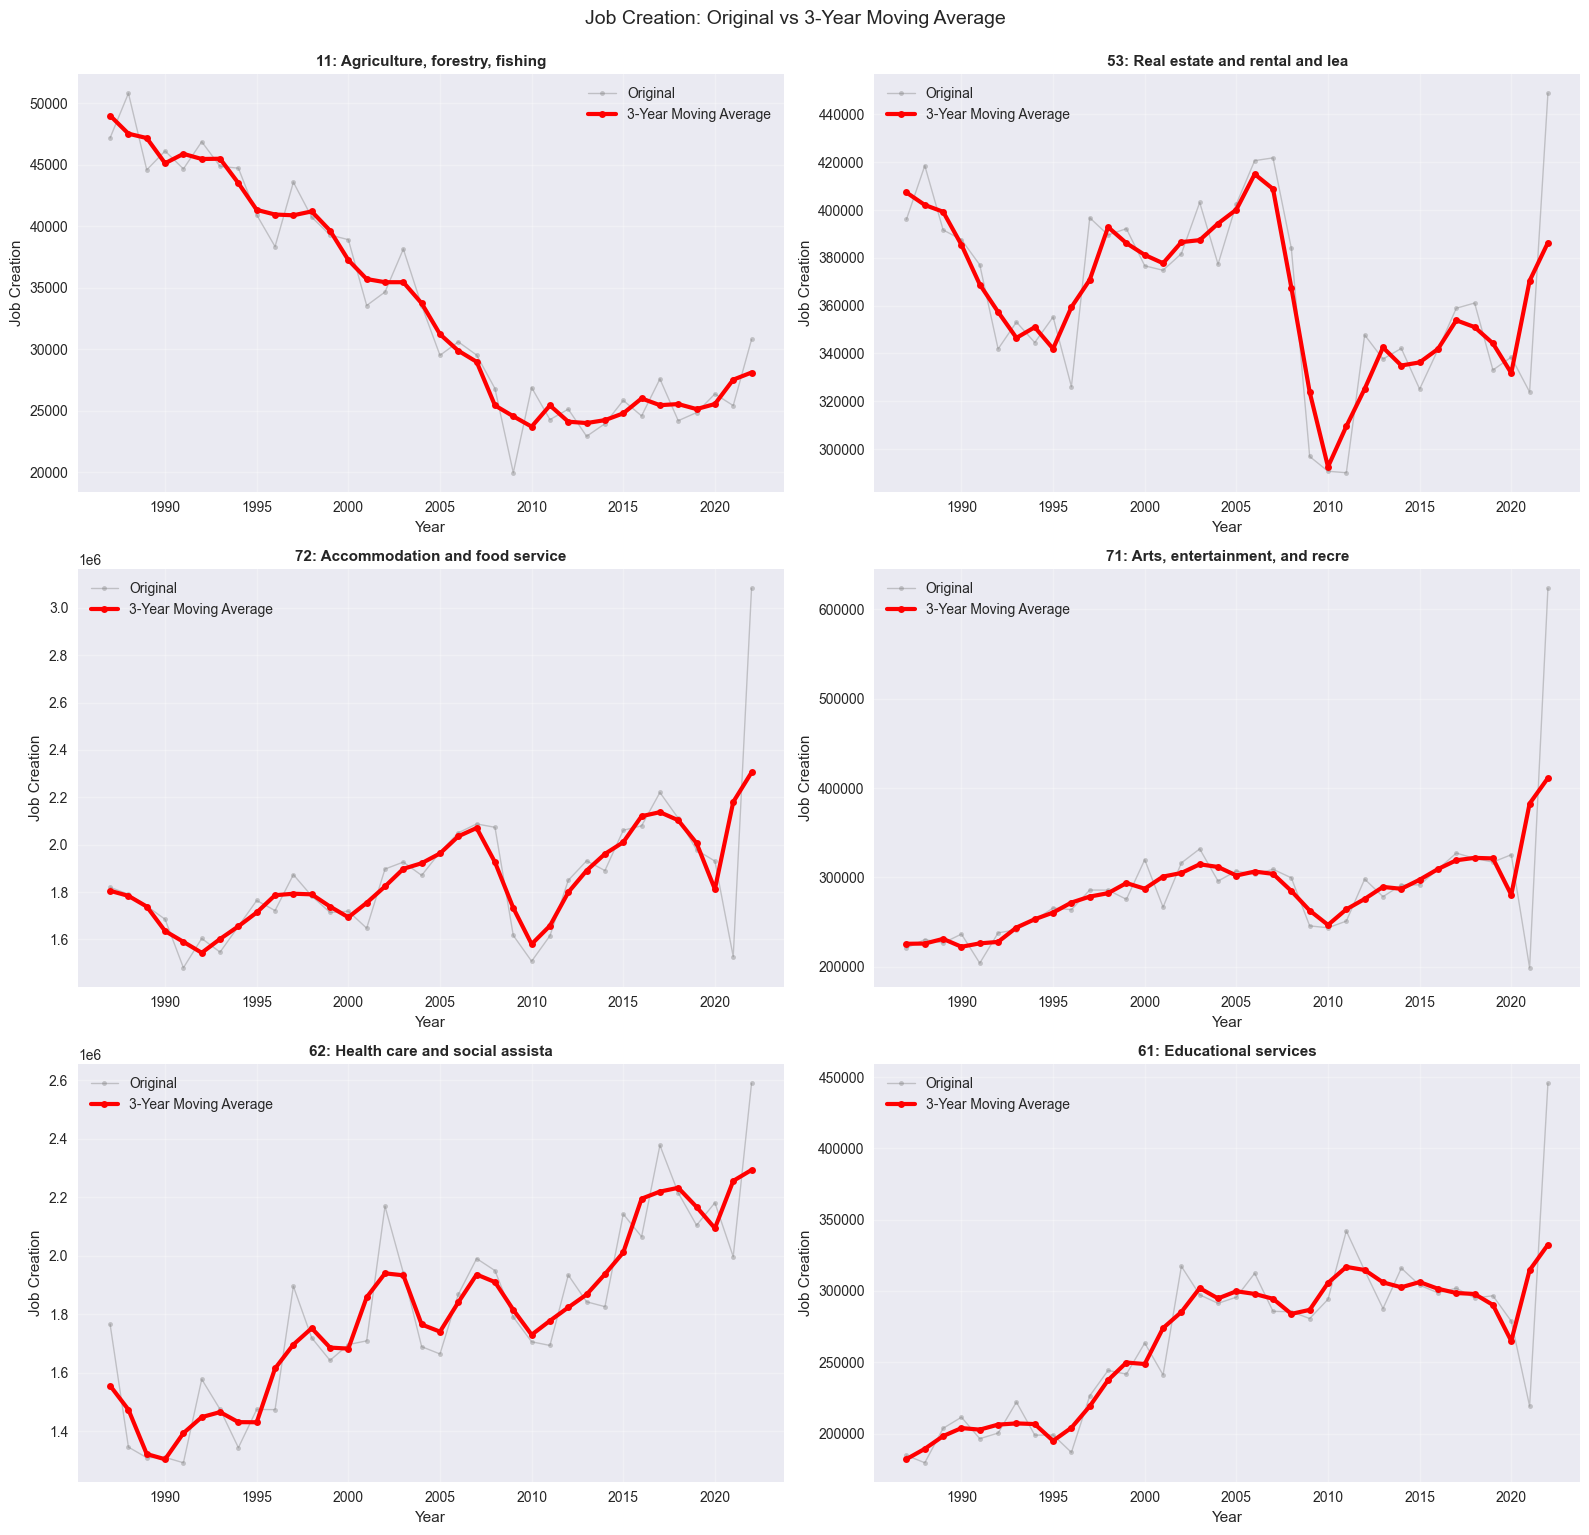

In [85]:
# Just create moving averages without plotting
job_variables = ['job_creation', 'job_creation_rate', 'net_job_creation']
df_with_ma = create_simple_moving_averages(merged, job_variables)

# Then plot whatever you want
plot_specific_variable(df_with_ma, 'job_creation')